# Proof-of-Concept: Wiener's Attack on RSA

This notebook presents a proof-of-concept implementation of Wiener's attack
against RSA. It shows how to generate vulnerable RSA keys, recover the private
key using continued fractions, and evaluate the empirical limits of the attack.


## Setup and basic helper functions

In this section, helper routines are defined to generate RSA moduli that are
deliberately vulnerable to Wiener's attack.

### Random balanced primes

The function below generates two random primes of a given bit-size such that
they are balanced: the smaller one is q, the larger one is p, and they satisfy
q < p < 2q.



In [ ]:
def rand_primes(size):
    """
    Generates two random primes of 'size' bits with q < p < 2q.
    """
    while True:
        p = random_prime(1 << (size - 1), 1 << size)
        q = random_prime(1 << (size - 1), 1 << size)
        # Ensure q < p
        if q > p:
            p, q = q, p
        # Ensure q < p < 2q
        if q < p < 2*q:
            return p, q

### Simple vulnerable key generation

The first function enforces the classical Wiener bound \(d < \frac{1}{3} n^{1/4}\)
and chooses a small prime d in this range before computing the corresponding
public exponent \(e\) as the modular inverse of d modulo \(\varphi(n)\).



In [1]:
def generate_vulnerable_rsa_key(bits=256, verbose=True):
    """
    Generates a large, vulnerable RSA key pair, with d < 1/3 n^{1/4}.
    """
    if verbose:
        print(f"--- 1. Generating a Vulnerable {bits}-bit RSA Key ---")

    # Generate large random primes, satisfying q < p < 2q
    p, q = rand_primes(bits // 2)
    n = p * q
    phi_n = (p - 1) * (q - 1)

    # Calculate the maximum d allowed by Wiener's condition: d < (1/3) * n^(1/4)
    max_d = Integer(round(1/3 * n**(1/4)))

    # Choose a small 'd' to ensure the attack succeeds
    d = random_prime(max_d // 100, lbound=1)

    # Calculate the public exponent 'e' using modular inverse
    e = inverse_mod(d, phi_n)
    if verbose:
        print(f"Modulus n bit length: {n.nbits()}")
        print(f"Maximum safe d (for Wiener's attack): {max_d.nbits()} bits")
        print(f"Chosen d: {d} ({d.nbits()} bits)")
    return n, e, d, p, q


### Key generation with d / N^(1/4) ratio

The second function allows more fine-grained control: it constrains the private
exponent d to lie inside a given ratio interval

\[
d_{\min} \cdot N^{1/4} \le d < d_{\max} \cdot N^{1/4},
\]

so that one can explore how the attack behaves below, near, and above the
theoretical Wiener bound.



In [1]:
def generate_vulnerable_rsa_key_with_ratio(bits=256, d_min_ratio=0.0, d_max_ratio=0.25, verbose=True):
    """
    Generates a vulnerable RSA key pair with a private exponent d constrained
    to a specific interval relative to N^(1/4) using SageMath functions.
    The interval is: d_min_ratio * N^(1/4) <= d < d_max_ratio * N^(1/4).
    """
    if verbose:
        print(f"--- 1. Generating a Vulnerable {bits}-bit RSA Key ---")
        print(f"d ratio interval: [{d_min_ratio}, {d_max_ratio}) * N^(1/4)")
    
    attempts = 0
    max_attempts = 1000

    while attempts < max_attempts:
        # 1. Generate large random primes
        p, q = rand_primes(bits // 2)
        n = p * q
        phi_n = (p - 1) * (q - 1)

        # 2. Calculate the N^(1/4) factor (N is a Sage Integer, so N**(1/4) is a Real Number)
        n_quarter = n**(1/4)

        # 3. Determine the required bounds for d
        d_min_val = d_min_ratio * n_quarter
        d_max_val = d_max_ratio * n_quarter

        # Convert Real Numbers to Integer using rounding (fixes TypeError)
        d_min = Integer(round(d_min_val))
        d_max = Integer(round(d_max_val))

        # Ensure d_min is at least 3 (d must be coprime to the even phi_n)
        if d_min < Integer(3):
            d_min = Integer(3)

        # Ensure bounds are valid for search
        if d_max <= d_min:
            attempts += 1
            continue

        # 4. Use random_prime to find a prime 'd' in the constrained interval [d_min, d_max)
        
        # We try to find a prime d in the range for a limited number of sub-attempts
        d_search_attempts = 50
        found_d = False

        for _ in range(d_search_attempts):
            try:
                # Use random_prime with lbound and up to d_max (exclusive)
                d = random_prime(d_max - 1, lbound=d_min) 
            except ValueError:
                # If d_max - 1 is too small or range is invalid, random_prime can raise error
                continue 
            
            # 5. Calculate the public exponent 'e' using modular inverse (SageMath function)
            try:
                # e = inverse_mod(d, phi_n) is the clearest SageMath way
                e = inverse_mod(d, phi_n)
                found_d = True
                break # Found valid d and e
            
            except ValueError:
                # inverse_mod failed (d and phi_n are not coprime). Try next random prime.
                continue

        if found_d:
            # Key generation successful
            if verbose:
                    max_d_wiener = Integer(round(Integer(1)/Integer(3) * n_quarter))
                    print(f"Modulus N bit length: {n.nbits()}")
                    print(f"N^(1/4) factor: {float(n_quarter):.2f}")
                    print(f"Wiener Bound d < (1/3) * N^(1/4): {max_d_wiener} ({max_d_wiener.nbits()} bits)")
                    print(f"Required d range: [{d_min}, {d_max})")
                    print(f"Chosen d: {d} ({d.nbits()} bits)")
                    print(f"d/N^(1/4) ratio: {float(d/n_quarter):.4f}")

            return n, e, d, p, q
        
        # If the inner loop fails, try a new key pair (p, q).
        attempts += 1
        
    raise RuntimeError(f"Failed to generate a key within the specified d ratio range [{d_min_ratio}, {d_max_ratio}) after {max_attempts} outer attempts.")

## Wiener's attack implementation

This section describes the core attack logic based on continued fractions.

### Continued fractions and convergents

Wiener's attack relies on the continued fraction expansion of the rational
number \(e/n\). For each convergent \(k/d'\) of this expansion, the algorithm
treats \(d'\) as a candidate private exponent and reconstructs a candidate
\(\varphi(n)\), then checks whether it yields valid RSA factors.



In [2]:
def wiener_attack(n, e, return_convergents_count=False, verbose=True):
    """
    Implements Wiener's attack by checking the convergents of e/n.
    If return_convergents_count is True, returns (d, p, q, count), otherwise (d, p, q).
    Set verbose=False to disable print statements.
    """
    if verbose:
        print("\n--- 2. Starting Wiener's Attack ---")

    target_fraction = Rational((e, n))
    cf_expansion = continued_fraction(target_fraction)
    if verbose:
        print(f"Continued Fraction Expansion Coefficients (a_i): {cf_expansion}")

    if verbose:
        print("Testing Convergents...")

    convergents_list = list(cf_expansion.convergents())
    count = 0
    for i, convergent in enumerate(convergents_list):
        k = convergent.numerator()
        d_cand = convergent.denominator()
        if k == 0:
            continue
        count += 1
        if (e * d_cand - 1) % k == 0:
            phi_cand = (e * d_cand - 1) // k
            sum_pq = n - phi_cand + 1
            discriminant = sum_pq^2 - 4 * n
            if discriminant >= 0 and isqrt(discriminant)^2 == discriminant:
                sqrt_discriminant = isqrt(discriminant)
                p_cand = (sum_pq + sqrt_discriminant) // 2
                q_cand = (sum_pq - sqrt_discriminant) // 2
                if p_cand * q_cand == n and p_cand > 1 and q_cand > 1:
                    if verbose:
                        print(f"\n[SUCCESS] Key found at convergent #{i+1}")
                        print(f"Candidate d: {d_cand}")
                        print(f"Candidate p: {p_cand}")
                        print(f"Candidate q: {q_cand}")
                    if return_convergents_count:
                        return d_cand, p_cand, q_cand, count
                    return d_cand, p_cand, q_cand
    if verbose:
        print("\n[FAILURE] Attack failed to find the key within the convergents.")
    if return_convergents_count:
        return None, None, None, count
    return None, None, None


When a convergent leads to an integer discriminant and factorization \(n = p q\)
with \(p, q > 1\), the key is considered successfully recovered.


## Single-key attack demo

This section demonstrates the attack end-to-end on a single vulnerable key.

1. Generate one RSA key of a chosen bit-length that satisfies Wiener's condition.
2. Run the attack and recover the private exponent and the prime factors.
3. Verify that:
   - the recovered d matches the true private exponent,
   - the recovered factors multiply back to n,
   - the recovered d is the modular inverse of e modulo \(\varphi(n)\).



In [3]:
# 1. Generate the vulnerable key
n, e, d_true, p_true, q_true = generate_vulnerable_rsa_key(bits=512)

# 2. Run the attack
d_found, p_found, q_found = wiener_attack(n, e)

# 3. Verification
print("\n--- 3. Verification ---")
if d_found is not None:
    print(f"True d: {d_true}")
    print(f"Found d: {d_found}")
    print(f"Match: {d_true == d_found}")
    
    # Sanity check on factorization
    print(f"True factors: ({p_true}, {q_true})")
    print(f"Found factors: ({p_found}, {q_found})")
    print(f"Factors Match: {(p_true == p_found and q_true == q_found) or (p_true == q_found and q_true == p_found)}")
    
    # --- NEW CRYPTOGRAPHIC CHECK ---
    phi_found = (p_found - 1) * (q_found - 1)
    e_inverse = inverse_mod(e, phi_found)
    print(f"\n[CRYPTOGRAPHIC CHECK]")
    print(f"Inverse of e mod phi: {e_inverse}")
    print(f"d_found matches inverse: {d_found == e_inverse}")

else:
    print("Attack failed or a bug occurred in the implementation logic.")

--- 1. Generating a Vulnerable 512-bit RSA Key ---
Modulus n bit length: 510
Maximum safe d (for Wiener's attack): 126 bits
Chosen d: 176043088297311925334348958168178543 (118 bits)

--- 2. Starting Wiener's Attack ---
Continued Fraction Expansion Coefficients (a_i): [0; 1, 2, 1, 1, 1, 12, 1, 3, 8, 1, 2, 4, 1, 2, 3, 24, 1, 4, 1, 1, 16, 68, 1, 9, 8, 7, 1, 1, 17, 3, 1, 8, 5, 9, 8, 1, 2, 2, 1, 51, 2, 2, 1, 1, 2, 1, 16, 175, 5, 3, 4, 2, 12, 3, 1, 1, 1, 1, 4, 4, 1, 1, 2, 1, 1, 2, 1, 977073, 1, 18, 11, 1, 3, 1, 3, 41, 1, 1, 1, 1, 4, 1, 5, 4, 2, 9, 1, 1, 2, 2, 52, 6, 17, 1, 4, 101, 3, 14, 2, 3, 1, 1, 2, 1, 393, 3, 3, 2, 1, 3, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 110, 3, 2, 1, 12, 1, 11, 1, 1, 2, 3, 2, 2, 1, 2, 4, 3, 24, 1, 2, 11, 2, 5, 1, 29, 2, 1, 7, 1, 2, 2, 2, 4, 1, 7, 1, 1, 2, 3, 1, 1, 2, 1, 2, 4, 4, 3, 1, 2, 5, 1, 2, 8, 4, 1, 2, 3, 1, 1, 1, 2, 1, 5, 5, 13, 63, 3, 2, 3, 2, 1, 1, 3, 11, 13, 8, 1, 1, 8, 1, 3, 1, 2, 2, 2, 1, 4, 1, 1, 1, 80, 1, 3, 1, 1, 3, 1, 5, 1, 2, 1, 3, 2, 2, 6, 1

## Extended experiments over d / N^(1/4)

This section runs larger experimental campaigns to quantify the empirical
success probability and cost of Wiener's attack as d grows relative to \(N^{1/4}\).

### Batch experiment driver

The function below loops over multiple key sizes and multiple d / N^(1/4)
intervals. For each configuration it:

- generates many vulnerable keys in the specified ratio range,
- runs Wiener's attack and checks correctness,
- records success rate, number of convergents, and execution time.



In [11]:
import numpy as np 
import time
def run_experiments_d_ranges(bit_sizes, d_ranges, trials_per_combo=50):
    """
    Runs experimental campaigns of Wiener's attack over multiple key sizes
    and multiple ranges of d / N^(1/4).

    Parameters:
        bit_sizes (list):
            List of n bit-lengths, e.g. [1024, 2048].
        d_ranges (list of (float, float)):
            Intervals for d / N^(1/4), e.g.:
            [(0.0, 0.1), (0.1, 0.5), (0.5, 1.0), (1.0, 1.5)].
        trials_per_combo (int):
            Number of keys generated and attacked for each
            (bit_size, d_range) pair.

    Returns:
        results (list of tuples):
            (bit_size, d_min_ratio, d_max_ratio, success_rate,
             avg_convergents, std_convergents, min_convergents, max_convergents,
             avg_time, std_time, min_time, max_time)
    """
    results = []
    total = int(len(bit_sizes) * len(d_ranges) * trials_per_combo)
    completed = 0
    
    for bits in bit_sizes:
        for (d_min_ratio, d_max_ratio) in d_ranges:
            convergents_list = []
            times = []
            successes = 0
            
            print(f"\n[+] Running experiments for n = {int(bits)} bits, "
                  f"d / N^(1/4) in [{d_min_ratio}, {d_max_ratio})")
            
            for trial_idx in range(1, int(trials_per_combo) + 1):
                n, e, d, p, q = generate_vulnerable_rsa_key_with_ratio(
                    bits,
                    d_min_ratio=d_min_ratio,
                    d_max_ratio=d_max_ratio,
                    verbose=False
                )
                
                start = time.time()
                # Assumes wiener_attack is implemented and returns 
                # (found_d, found_p, found_q, num_convergents)
                found_d, found_p, found_q, num_convergents = wiener_attack(
                    n, e, return_convergents_count=True, verbose=False
                )
                elapsed = time.time() - start
                
                times.append(elapsed)
                convergents_list.append(num_convergents)
                
                if found_d is not None and found_p is not None and found_q is not None:
                    if found_p * found_q == n and found_p > 1 and found_q > 1:
                        phi_found = (found_p - 1) * (found_q - 1)
                        if (e * found_d) % phi_found == 1:
                            successes += 1    
                completed += 1
                percent = (completed / total) * 100.0
                print(
                    f"    Trial {trial_idx}/{int(trials_per_combo)} "
                    f"(Global: {completed}/{total}, {percent:.1f}%)",
                    end="\r"
                )
            conv_np = np.array(convergents_list, dtype=float)
            times_np = np.array(times, dtype=float)
            success_rate = successes / float(trials_per_combo)
            
            results.append((
                int(bits),
                float(d_min_ratio), float(d_max_ratio),
                success_rate,
                float(conv_np.mean()), float(conv_np.std()),
                int(conv_np.min()), int(conv_np.max()),
                float(times_np.mean()), float(times_np.std()),
                float(times_np.min()), float(times_np.max())
            ))
            
            print(
                f"\n    [✓] Done for {int(bits)} bits, "
                f"ratio [{d_min_ratio}, {d_max_ratio}). "
                f"Success rate: {success_rate:.3f}, "
                f"Avg. convergents: {conv_np.mean():.2f}, "
                f"Avg. time: {times_np.mean():.4f}s"
            )
            
    print("\n[+] All d-range experiments complete!\n")
    return results


### Running the extended experiments

Here, the notebook defines:

- the list of modulus sizes (e.g., 256, 512, 1024, 2048 bits),
- the list of ratio intervals (below, around, and above the Wiener bound),
- the number of trials per configuration,

and then launches the full experiment campaign.



In [14]:
# Define key sizes and d/N^(1/4) intervals to explore
bit_sizes = [256, 512, 1024, 2048]
d_ranges = [
    (0.0, 1/3),  # Below bound
    (1/3, 2/3),  # Near/Above bound
    (2/3, 3/3),  # Above bound
    (3/3, 4/3)   # Significantly above bound
]

# Run extended experiments
print("Starting Extended Wiener Attack Experiments...")
experiment_d_results = run_experiments_d_ranges(
    bit_sizes,
    d_ranges,
    trials_per_combo=500 # adjust up or down depending on time budget
)

Starting Extended Wiener Attack Experiments...

[+] Running experiments for n = 256 bits, d / N^(1/4) in [0.000000000000000, 1/3)
    Trial 500/500 (Global: 500/8000, 6.2%)
    [✓] Done for 256 bits, ratio [0.000000000000000, 1/3). Success rate: 1.000, Avg. convergents: 36.05, Avg. time: 0.0004s

[+] Running experiments for n = 256 bits, d / N^(1/4) in [1/3, 2/3)
    Trial 500/500 (Global: 1000/8000, 12.5%)
    [✓] Done for 256 bits, ratio [1/3, 2/3). Success rate: 0.942, Avg. convergents: 43.64, Avg. time: 0.0004s

[+] Running experiments for n = 256 bits, d / N^(1/4) in [2/3, 1)
    Trial 500/500 (Global: 1500/8000, 18.8%)
    [✓] Done for 256 bits, ratio [2/3, 1). Success rate: 0.526, Avg. convergents: 90.12, Avg. time: 0.0005s

[+] Running experiments for n = 256 bits, d / N^(1/4) in [1, 4/3)
    Trial 500/500 (Global: 2000/8000, 25.0%)
    [✓] Done for 256 bits, ratio [1, 4/3). Success rate: 0.232, Avg. convergents: 121.78, Avg. time: 0.0005s

[+] Running experiments for n = 512 b

## Result visualization and interpretation

This final section turns the aggregated experiment data into tables and plots.

### Building the summary table

The helper function below converts the raw results into a pandas DataFrame,
prints a markdown table (e.g. for export to reports) and annotates each row
with the midpoint of the d / \(N^{1/4}\) ratio interval.



In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def show_d_range_results(experiment_results):
    """
    Builds a DataFrame from d-range experiments and produces plots that show
    how success rate, average convergents, and execution time change
    as d moves closer to or beyond the theoretical Wiener bound.
    """
    df = pd.DataFrame(
        experiment_results,
        columns=[
            "Bit-Length N",
            "d_min_ratio", "d_max_ratio",
            "Success Rate",
            "Avg. Convergents", "Std Convergents",
            "Min Convergents", "Max Convergents",
            "Avg. Time (s)", "Std Time (s)",
            "Min Time (s)", "Max Time (s)"
        ]
    )
    
    print("\n=== d-Range Experiment Results Table ===")
    # Using df.to_markdown for clean output
    print(df.to_markdown(index=False, tablefmt="github"))

    # Calculate the midpoint of the d/N^(1/4) ratio for plotting on the X-axis
    df["Ratio Midpoint"] = (df["d_min_ratio"] + df["d_max_ratio"]) / 2.0
    
    # --- Plot 1: Success Rate vs d / N^(1/4) ---
    # This plot shows the primary outcome: how often the attack succeeds.
    plt.figure(figsize=(9, 6))
    for bits in sorted(df["Bit-Length N"].unique()):
        sub = df[df["Bit-Length N"] == bits]
        plt.plot(sub["Ratio Midpoint"], sub["Success Rate"], marker="o", linestyle="none", label=f"N = {bits} bits")
    
    # Add the theoretical Wiener Bound line (d/N^(1/4) < 1/3 ≈ 0.333)
    plt.axvline(x=1/3, color='r', linestyle='--', label='Theoretical Wiener Bound (1/3)')
    
    plt.title("Wiener Attack Success Rate vs. Relative Private Exponent Size")
    plt.xlabel(r"$d / N^{1/4}$ (Ratio Midpoint)")
    plt.ylabel("Success Rate")
    plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # 

    # --- Plot 2: Average Convergents vs d / N^(1/4) ---
    # This plot shows the complexity/depth of the attack for successful cases.
    plt.figure(figsize=(9, 6))
    for bits in sorted(df["Bit-Length N"].unique()):
        sub = df[df["Bit-Length N"] == bits]
        plt.plot(sub["Ratio Midpoint"], sub["Avg. Convergents"], marker="s", linestyle=":", label=f"N = {bits} bits (Avg.)")
        # Optional: Add the range fill, similar to the original function
        plt.fill_between(sub["Ratio Midpoint"], sub["Min Convergents"], sub["Max Convergents"], alpha=0.1, label=f"N = {bits} bits (Min-Max)")

    plt.title("Average Convergents Tested vs. Relative Private Exponent Size")
    plt.xlabel(r"$d / N^{1/4}$ (Ratio Midpoint)")
    plt.ylabel("Average Convergents Tested")
    plt.grid(True, linestyle="none", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Average Execution Time vs d / N^(1/4) ---
    # This plot shows the performance cost of the attack.
    plt.figure(figsize=(9, 6))
    for bits in sorted(df["Bit-Length N"].unique()):
        sub = df[df["Bit-Length N"] == bits]
        plt.plot(sub["Ratio Midpoint"], sub["Avg. Time (s)"], marker="d", linestyle="--", label=f"N = {bits} bits (Avg.)")
        plt.fill_between(sub["Ratio Midpoint"], sub["Min Time (s)"], sub["Max Time (s)"], alpha=0.1, label=f"N = {bits} bits (Min-Max)")

    plt.title("Execution Time vs. Relative Private Exponent Size")
    plt.xlabel(r"$d / N^{1/4}$ (Ratio Midpoint)")
    plt.ylabel("Execution Time (seconds)")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df


### Plots: success rate, convergents, and time

The function then generates three plots:

- **Success Rate vs d / N^(1/4)**, with a vertical line at the theoretical bound \(1/3\).
- **Average Convergents Tested vs d / N^(1/4)**, including min–max bands.
- **Execution Time vs d / N^(1/4)**, showing the performance cost of the attack.

Together, these plots illustrate how closely the empirical behaviour of the
attack follows and actually exceeds the classical Wiener bound.



=== d-Range Experiment Results Table ===
|   Bit-Length N |   d_min_ratio |   d_max_ratio |   Success Rate |   Avg. Convergents |   Std Convergents |   Min Convergents |   Max Convergents |   Avg. Time (s) |   Std Time (s) |   Min Time (s) |   Max Time (s) |
|----------------|---------------|---------------|----------------|--------------------|-------------------|-------------------|-------------------|-----------------|----------------|----------------|----------------|
|            256 |      0        |      0.333333 |          1     |             36.052 |           4.7097  |                19 |                51 |     0.00041761  |    6.48116e-05 |    0.000321865 |    0.00104618  |
|            256 |      0.333333 |      0.666667 |          0.942 |             43.642 |          26.5063  |                25 |               162 |     0.000435395 |    5.54197e-05 |    0.000348806 |    0.000906467 |
|            256 |      0.666667 |      1        |          0.526 |             90.122

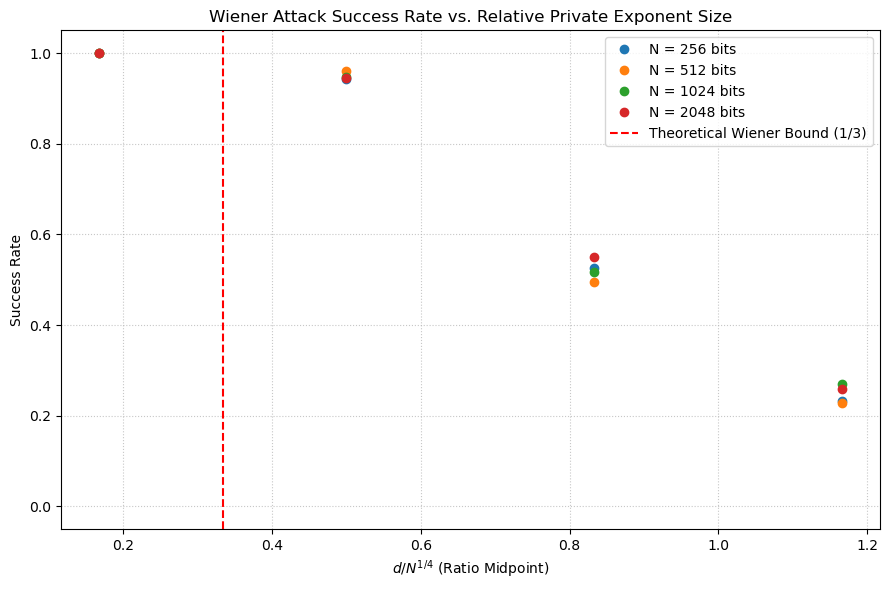

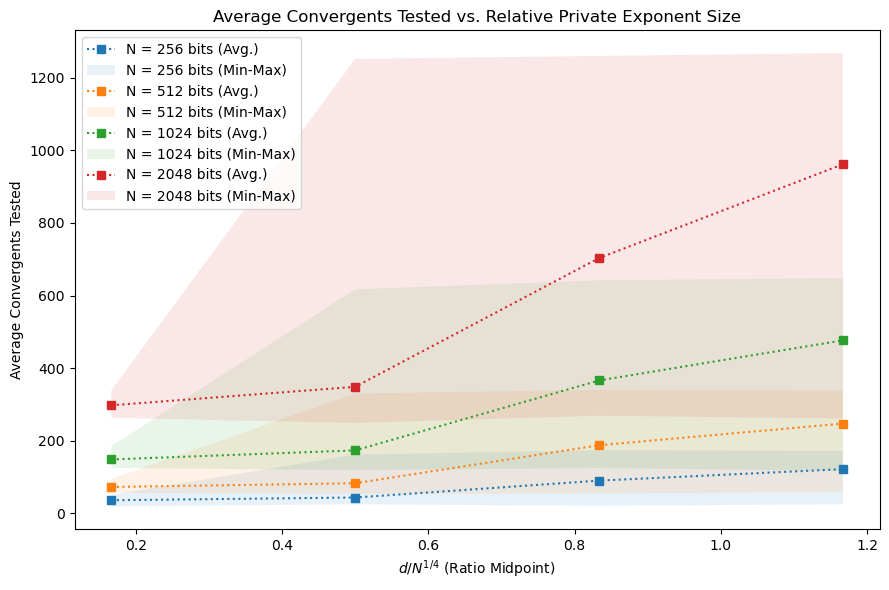

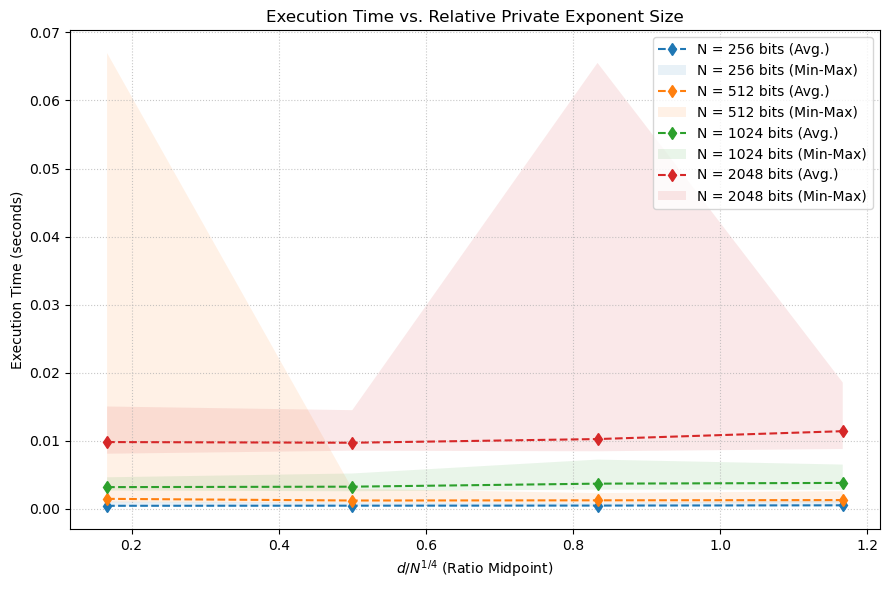


DataFrame containing all experimental results is stored in df_d.


In [16]:
# Show results
df_d = show_d_range_results(experiment_d_results)
print("\nDataFrame containing all experimental results is stored in df_d.")

Finally, export data to CSV for plotting in LaTeX.

In [17]:
df_d.to_csv("wiener_d_range_results.csv", index=False)